# Case 5 - Proxy Estimation (SC~Tritium)
Welcome to the demonstration notebook where we'll estimate the tritium using Specific Conductance as a Proxy using the **pylenm** package!<br>
Let’s get started!

## Setup
Make sure to install pylenm from https://pypi.org/project/pylenm/ by running `pip install pylenm` in your environment terminal. Once completed, you should be able to import the package. Note: to update to the latest version of pylenm run: `pip install pylenm --upgrade`

In [1]:
# pip install pylenm

In [2]:
# pip install pyproj

In [3]:
# pip install rasterio

In [4]:
# pip install elevation

In [5]:
# pip install richdem

In [6]:
# Basics
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import  MinMaxScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from math import sqrt
from sklearn.metrics import r2_score

# pylenm
import pylenm
print("pylenm version: ", pylenm.__version__)
from pylenm import PylenmDataFactory

# GIS data layers
from pyproj import Transformer, CRS
import rasterio
import elevation
import richdem as rd

plt.rcParams["font.family"] = "Times New Roman"

pylenm version:  0.2


In [7]:
# Load GIS elevation data
# UNCOMMENT THE 2 LINES BELOW IF YOU DO NOT HAVE THE DEM FILE ALREADY
# dem_path = os.path.join(os.getcwd(), 'FArea-30m-DEM_cropped.tif')
# elevation.clip(bounds=(-81.6855, 33.2657, -81.6734, 33.2785), output=dem_path)

# IF YOU DO HAVE THE DEM FILE ALREADY
dem_path = "./data/FArea-30m-DEM_cropped.tif"


farea_dem = rd.LoadGDAL(dem_path)
farea_ras = rasterio.open(dem_path)

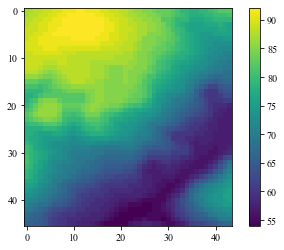

In [8]:
plt.imshow(farea_dem, interpolation='none')
plt.colorbar()
plt.show()

In [9]:
crs = CRS.from_epsg("26917")
proj = Transformer.from_crs(crs.geodetic_crs, crs)

x_loc = np.zeros([farea_ras.height, farea_ras.width])
y_loc = np.zeros([farea_ras.height, farea_ras.width])
for i in range(farea_ras.height):
  for j in range(farea_ras.width):
    lon = farea_ras.xy(i,j)[0]
    lat = farea_ras.xy(i,j)[1]
    utm_x, utm_y =proj.transform(lat,lon) # Latitude/Longitude to UTM
    x_loc[i,j] = utm_x
    y_loc[i,j] = utm_y

In [10]:
slope = rd.TerrainAttribute(farea_dem, attrib='slope_riserun')
accum = rd.FlowAccumulation(farea_dem, method='D8')
twi   = np.log(accum/slope)

## Load Well Time Series Data + Preprocess

In [11]:
# Load and process well time-series data
url_1 = 'https://raw.githubusercontent.com/ALTEMIS-DOE/pylenm/master/notebooks/data/FASB_Data_thru_3Q2015_Reduced_Demo.csv'
url_2 = 'https://github.com/ALTEMIS-DOE/pylenm/blob/master/notebooks/data/FASB%20Well%20Construction%20Info.xlsx?raw=true'
concentration_data = pd.read_csv(url_1)
construction_data = pd.read_excel(url_2)
pylenm_df = PylenmDataFactory(concentration_data)
pylenm_df.simplify_data(inplace=True)
pylenm_df.setConstructionData(construction_data)

Successfully imported the data!

Successfully imported the construction data!



Data summary for water table

In [12]:
analyte = 'TRITIUM'
tr_details = pylenm_df.get_analyte_details(analyte)
tr_details

,Start Date,End Date,Date Range (days),Unique samples
Well Name,,,,
FSB 77,1990-01-01,2006-10-16,6132,65
FSB111C,1990-01-01,2006-10-17,6133,67
FSB105C,1990-01-01,2006-10-19,6135,67
FSB111D,1990-01-01,2006-10-26,6142,68
FSB107D,1990-01-01,2007-02-01,6240,68
...,...,...,...,...
FSB146D,2015-04-29,2015-09-09,133,9
FSB145D,2015-04-30,2015-09-09,132,9
FSB143D,2015-05-04,2015-09-09,128,9


Select wells that have enough and recent samples

In [13]:
n_samples = tr_details['Unique samples']
end_date = tr_details['End Date']
start_date = tr_details['Start Date']
well_names  = tr_details.index
well_enough = well_names[n_samples>20]

In [14]:
well_recent = well_names[end_date> datetime.strptime('2015-01-01', '%Y-%m-%d').date()]
well_old    = well_names[start_date< datetime.strptime('2006-01-01', '%Y-%m-%d').date()]

Temporal interpolation of the time series at equal frequency

In [15]:
tr_interp = pylenm_df.interpolate_wells_by_analyte('TRITIUM', frequency='1M', rm_outliers=True, z_threshold=3)
sc_interp = pylenm_df.interpolate_wells_by_analyte('SPECIFIC CONDUCTANCE', frequency='1M', rm_outliers=True, z_threshold=3)

tr_interp.index = pd.to_datetime(tr_interp.index)
sc_interp.index = pd.to_datetime(sc_interp.index)

tr_interp[tr_interp <= 0] = 0.001
sc_interp[sc_interp <= 0] = 0.001

Select the upper aquifer wells and the wells that have enough samples

44 wells


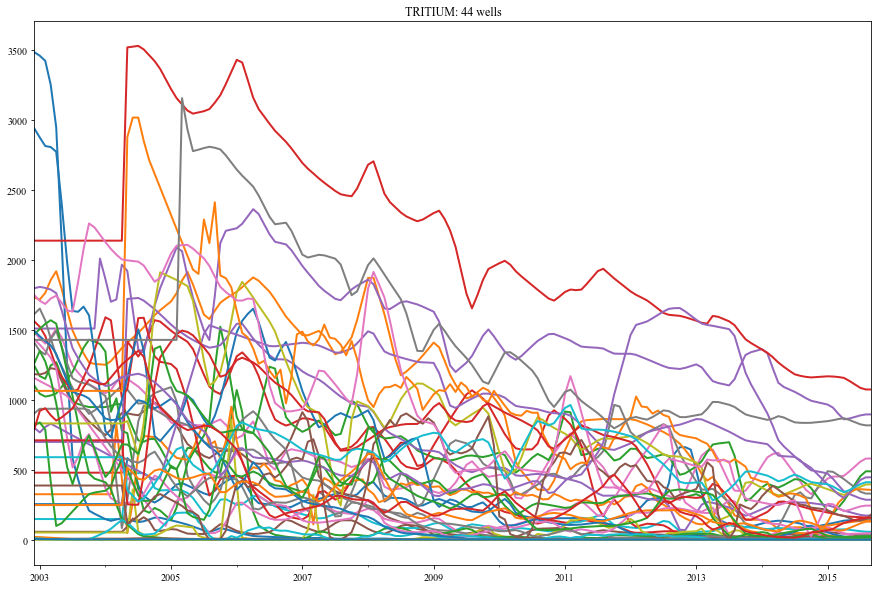

In [16]:
active = list(np.unique(pylenm_df.filter_by_column(pylenm_df.get_Construction_Data(), col='WELL_USE', equals=['ACTIVE']).index))
upper_wells = list(np.unique(pylenm_df.filter_by_column(pylenm_df.get_Construction_Data(), col='AQUIFER', equals=['UAZ_UTRAU']).index))
well_only_D = list(set(upper_wells) & set(tr_interp.columns)& set(well_enough)& set(well_recent)& set(well_old) & set(active))
tr_interp = tr_interp[well_only_D]
tr_interp.plot(figsize=(15,10), legend=False, linewidth=2, title=str(analyte + ": {} wells".format(tr_interp.shape[1])))
print(tr_interp.shape[1], "wells")

Let's remove the 'bad' time series wells

In [17]:
# bad_ones = ['FSB 89D', 'FSB128D', 'FSB104D', 'FSB 91D', 'FSB 99D']
bad_ones = ['FSB 89D', 'FSB128D', 'FSB104D', 'FSB 91D', 'FSB 99D', 'FSB117D']
tr_interp = tr_interp.drop(columns=bad_ones)
sc_interp = sc_interp.drop(columns=bad_ones)

In [18]:
# Reorder columns to be in alphabetical order
tr_interp = tr_interp.reindex(sorted(tr_interp.columns), axis=1)
sc_interp = sc_interp.reindex(sorted(sc_interp.columns), axis=1)

38 wells


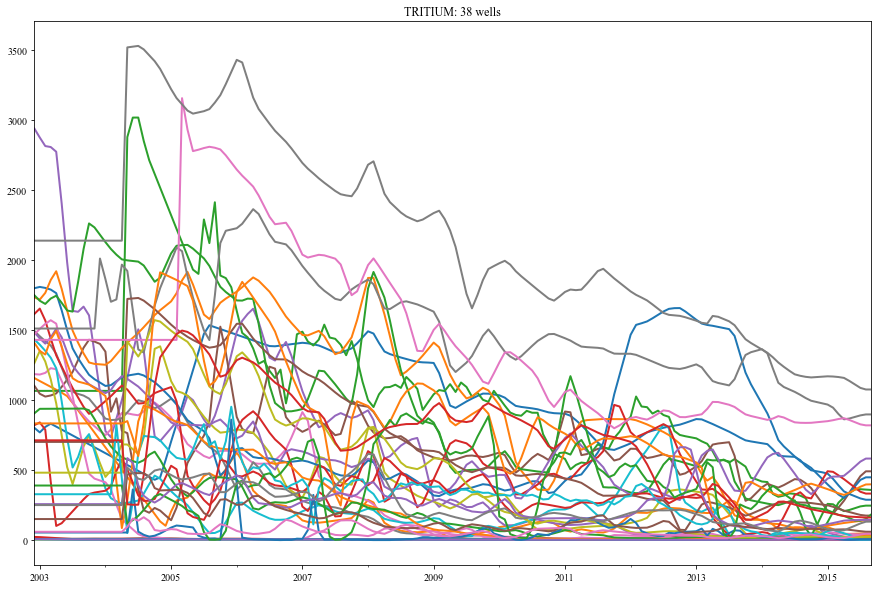

In [19]:
tr_interp.plot(figsize=(15,10), legend=False, linewidth=2, title=str(analyte + ": {} wells".format(tr_interp.shape[1])))
print(tr_interp.shape[1], "wells")

## Well Location Data

In [20]:
well_info = pylenm_df.get_Construction_Data()

Match the well indecies between the time series and locations

In [21]:
shared_wells = list(set(well_info.index) & set(tr_interp.columns) & set(sc_interp.columns))
tr_interp = tr_interp[shared_wells]
sc_interp = sc_interp[shared_wells]
# Reorder columns to be in alphabetical order
tr_interp = tr_interp.reindex(sorted(tr_interp.columns), axis=1)
sc_interp = sc_interp.reindex(sorted(sc_interp.columns), axis=1)

well_info = well_info.T[shared_wells]
# Reorder columns to be in alphabetical order
well_info = well_info.reindex(sorted(well_info.columns), axis=1)
well_info = well_info.T

In [22]:
tr_interp.columns == sc_interp.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [23]:
crs = CRS.from_epsg("26917")
proj = Transformer.from_crs(crs.geodetic_crs, crs)
UTM_x, UTM_y = proj.transform(well_info.LATITUDE,well_info.LONGITUDE)

Take out the ground-surface elevation, and compute the water table elevation

In [24]:
elev = well_info.REFERENCE_ELEVATION
elev.index = well_info.index
elev = elev.T
elev = elev * 0.3048 # convert to meters

In [25]:
X = np.vstack((UTM_x,UTM_y, elev.values)).T
X = pd.DataFrame(X, columns=['Easting', 'Northing', 'Elevation'])

In [26]:
tr_interp.describe().T['min'].min()

0.001

In [27]:
tr_interp_org = tr_interp.copy()

In [28]:
# tr_interp = np.log2(tr_interp)
# sc_interp = np.log2(sc_interp)
tr_interp = np.log10(tr_interp)
sc_interp = np.log10(sc_interp)

In [29]:
tr_interp

,FBI 14D,FEX 4,FOB 14D,FSB 76,FSB 78,FSB 79,FSB 87D,FSB 88D,FSB 90D,FSB 92D,...,FSB127D,FSB130D,FSB131D,FSB132D,FSB133D,FSB134D,FSB135D,FSB136D,FSB137D,FSB138D
2002-12-31,2.903764,3.063185,3.027356,1.353395,3.468039,3.042069,3.073518,3.174114,3.101269,3.156141,...,2.682325,2.515024,1.734074,2.920528,2.590491,2.852568,2.409483,2.176730,1.772457,2.397893
2003-01-31,2.885730,3.055056,3.027356,1.329030,3.458386,3.018845,3.072484,3.162797,3.130421,3.144452,...,2.682325,2.515024,1.734074,2.920528,2.590491,2.852568,2.409483,2.176730,1.772457,2.397893
2003-02-28,2.907177,3.047177,3.027356,1.279515,3.449092,3.010470,3.076760,3.152309,3.105345,3.130602,...,2.682325,2.515024,1.734074,2.920528,2.590491,2.852568,2.409483,2.176730,1.772457,2.397893
2003-03-31,2.919626,3.039152,3.027356,1.215138,3.448012,3.013792,3.088862,3.142686,3.059753,3.114500,...,2.682325,2.515024,1.734074,2.920528,2.590491,2.852568,2.409483,2.176730,1.772457,2.397893
2003-04-30,2.908479,3.030696,3.027356,1.141131,3.442795,3.019859,3.086225,3.123712,2.989577,3.088641,...,2.682325,2.515024,1.734074,2.920528,2.590491,2.852568,2.409483,2.176730,1.772457,2.397893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-05-31,2.517078,1.643946,2.526339,0.636542,1.340058,2.530298,1.635647,0.742970,1.379750,1.555014,...,1.298809,0.999693,0.343959,2.529802,2.194893,2.224281,2.151277,1.864802,1.353484,1.933172
2015-06-30,2.495705,1.658727,2.558872,0.605713,1.287065,2.599589,1.617317,0.750388,1.408488,1.367107,...,1.323637,0.684275,0.507969,2.555970,2.144813,2.218241,2.153774,1.835240,1.494101,2.010036
2015-07-31,2.473226,1.673021,2.560124,0.572891,1.226764,2.659331,1.598386,0.757681,1.435276,1.028571,...,1.346978,0.469931,0.738927,2.580650,2.143684,2.212116,2.156257,1.803518,1.600153,2.075320
2015-08-31,2.459468,1.681197,2.556741,0.559907,1.195900,2.690917,1.591065,0.761905,1.445604,0.515874,...,1.356026,0.450374,0.738248,2.598789,2.177327,2.207189,2.158219,1.776559,1.654612,2.118489


In [30]:
sc_interp

,FBI 14D,FEX 4,FOB 14D,FSB 76,FSB 78,FSB 79,FSB 87D,FSB 88D,FSB 90D,FSB 92D,...,FSB127D,FSB130D,FSB131D,FSB132D,FSB133D,FSB134D,FSB135D,FSB136D,FSB137D,FSB138D
2003-12-31,2.596304,2.508883,2.757937,1.590410,2.855760,2.732667,2.662317,2.742407,2.578782,2.811491,...,2.496138,2.410771,2.229227,2.654657,2.631815,2.583058,2.333533,2.295336,1.936838,2.223630
2004-01-31,2.587112,2.481147,2.757937,1.590727,2.779245,2.731826,2.651614,2.733131,2.576436,2.792156,...,2.496138,2.410771,2.229227,2.654657,2.631815,2.583058,2.333533,2.295336,1.936838,2.223630
2004-02-29,2.578028,2.452506,2.757937,1.603624,2.748712,2.601713,2.666657,2.725534,2.604006,2.757432,...,2.496138,2.410771,2.229227,2.654657,2.631815,2.583058,2.333533,2.295336,1.936838,2.223630
2004-03-31,2.568749,2.421841,2.757937,1.616558,2.759968,2.619434,2.689605,2.718363,2.639404,2.706378,...,2.496138,2.538448,2.229227,2.654657,2.631815,2.583058,2.333533,2.295336,1.936838,2.223630
2004-04-30,2.559108,2.388274,2.757937,1.627288,2.771218,2.620526,2.707118,2.712441,2.671624,2.654042,...,2.496138,2.450135,2.229227,2.654657,2.631815,2.583058,2.333533,2.295336,1.936838,2.223630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-05-31,2.609690,1.785266,2.492379,1.649282,2.434791,2.527112,2.020742,1.898608,2.470058,2.229071,...,1.750220,2.064149,1.703945,2.605324,2.305351,2.375908,1.796519,2.193472,1.832945,2.072069
2015-06-30,2.593711,1.750983,2.507055,1.638444,2.421520,2.488810,2.013862,1.904542,2.433415,2.191408,...,1.752592,2.014451,1.706616,2.629836,2.257541,2.359166,2.061170,2.203950,1.887574,2.115469
2015-07-31,2.577122,1.713760,2.507515,1.627448,2.407846,2.446800,2.006945,1.910396,2.393659,2.150166,...,1.754935,1.947407,1.653213,2.653038,2.253113,2.341752,2.226600,2.214181,1.936093,2.154924
2015-08-31,2.567081,1.690326,2.505821,1.623249,2.401401,2.420105,2.004321,1.913796,2.376577,2.123997,...,1.755875,1.881158,1.646593,2.670140,2.263022,2.327405,2.324067,2.222139,1.963514,2.178599


In [31]:
# GETS APPROXIMATE tr VALUE IN THE XX GRID
def get_approx_predictions(X, y_map, XX):
    X_approx, y_approx = [],[]
    for i in range(X.shape[0]):
        x1, y1 = X.iloc[i].Easting, X.iloc[i].Northing # ACTUAL POINT
        abs_east = np.abs(XX.Easting-x1)
        abs_north= np.abs(XX.Northing-y1)
        c = np.maximum(abs_north,abs_east)
        index = np.argmin(c)
        XX.iloc[index].Easting, XX.iloc[index].Northing
        X_approx.append([XX.iloc[index].Easting, XX.iloc[index].Northing, XX.iloc[index].Elevation])
        y_approx.append(y_map[index])
    X_approx = pd.DataFrame(X_approx, columns=['Easting', 'Northing', 'Elevation'])
    return X_approx, y_approx

In [32]:
X = np.vstack((UTM_x,UTM_y, elev.values)).T
X = pd.DataFrame(X, columns=['Easting', 'Northing', 'Elevation'])

XX = np.vstack([x_loc.flatten(), y_loc.flatten(), farea_dem.flatten(), slope.flatten(), accum.flatten()]).T
XX = pd.DataFrame(XX, columns=['Easting', 'Northing', 'Elevation', 'Slope', 'Acc'])

X_approx, Slope_X = get_approx_predictions(X, slope.flatten(), XX)
X_approx, Acc_X = get_approx_predictions(X, accum.flatten(), XX)

X = np.vstack((UTM_x,UTM_y, elev.values, Slope_X, Acc_X)).T
X = pd.DataFrame(X, columns=['Easting', 'Northing', 'Elevation', 'Slope', 'Acc'])

MSE:  0.14027368022084738
R^2:  0.8341993361009267


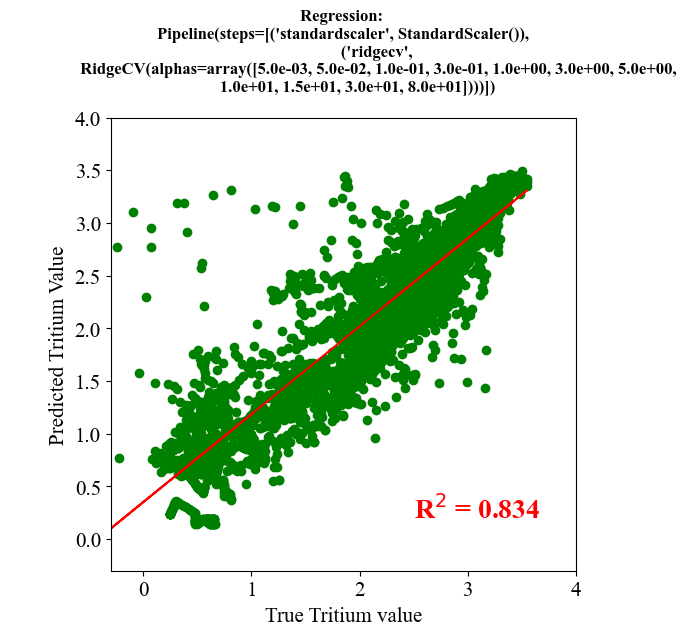

In [33]:
tr_all = tr_interp.iloc[12:,:].values.flatten()
sc_all = sc_interp.values.flatten()

X_train, X_test, y_train, y_test = train_test_split(sc_all, tr_all, test_size=0.2, random_state=365)

X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

alpha_Values = [0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 80]
reg = make_pipeline(StandardScaler(), RidgeCV(alphas=alpha_Values))

reg.fit(X=X_train, y=y_train)
predicted_tr = reg.predict(X_train)

fig, ax = plt.subplots(figsize=(6,6),dpi=100)
# plt.rcParams["legend.loc"] = 'upper left'
print("MSE: ",pylenm_df.mse(y_train, predicted_tr))
r2 = r2_score(y_train, predicted_tr)
print("R^2: ",r2)
fontsize = 15
ax.set_title('Regression: \n{}'.format(reg), y=1.04, fontweight='bold')
ax.set_xlabel('True Tritium value',fontsize=fontsize)
ax.set_ylabel('Predicted Tritium Value', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_xlim([-0.3, 4])
ax.set_ylim([-0.3, 4])
scatter1 = ax.scatter(y_train, predicted_tr, label = "Linear Regression + GP", c='g')

m_lr, b_lr = np.polyfit(y_train.flatten(), predicted_tr.flatten(), 1)

ax.plot(y_train, m_lr*y_train + b_lr, c='r')
ax.text(2.5,0.2,"R{} = {:.3f}".format('$^{2}$' ,r2), c='r', fontsize=20, fontweight='bold')
fig.show()
# PLOTS TRAINING SET

Correlation between the 38 average values: 0.913


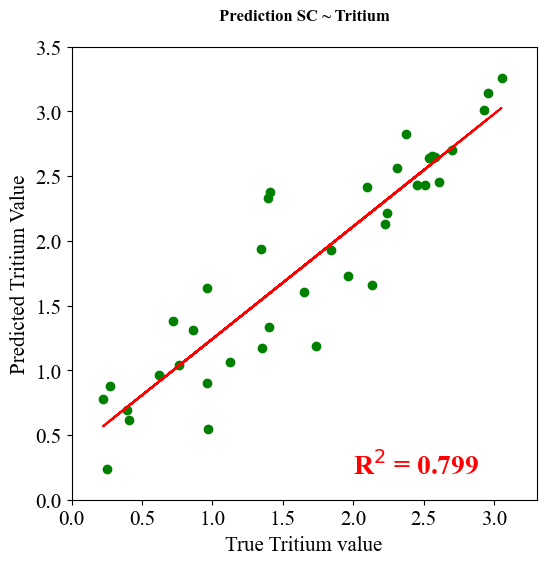

In [34]:
year = 2015
y_sc = np.array(sc_interp.loc[sc_interp.index[pd.Series(sc_interp.index).dt.year == year]].mean())
y_tr = np.array(tr_interp.loc[tr_interp.index[pd.Series(tr_interp.index).dt.year == year]].mean())

print("Correlation between the {} average values: {:0.3}".format(y_sc.shape[0],np.corrcoef(y_sc, y_tr) [0][1]))

# Predict TRITIUM based on SC average values
y_tr_pred = reg.predict(y_sc.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(6,6),dpi=100)

ax.set_title('Prediction SC ~ Tritium', y=1.04, fontweight='bold')
ax.set_xlabel('True Tritium value',fontsize=fontsize)
ax.set_ylabel('Predicted Tritium Value', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_xlim([0, 3.3])
ax.set_ylim([0, 3.5])

scatter1 = ax.scatter(y_tr, y_tr_pred, label = "Linear Regression + GP", c='g')

m_lr, b_lr = np.polyfit(y_tr.flatten(), y_tr_pred.flatten(), 1)

ax.plot(y_tr, m_lr*y_tr + b_lr, c='r')
ax.text(2,0.2,"R{} = {:.3f}".format('$^{2}$' ,r2_score(y_tr, y_tr_pred)), c='r', fontsize=20, fontweight='bold')
fig.show()

In [35]:
def dist(p1,p2):
    return sqrt(((p1[0]-p2[0])**2)+((p1[1]-p2[1])**2))

def add_dist_to_basin(XX, basin_coordinate=[436642.70,3681927.09], col_name='dist_to_basin'):
    x1,y1 = basin_coordinate
    distances = []
    for i in range(XX.shape[0]):
        x2,y2 = XX.iloc[i][0], XX.iloc[i][1]
        distances.append(dist([x1,y1],[x2,y2]))
    XX[col_name] = distances
    return XX

In [36]:
b_c=[436642.70,3681927.09]
XX = add_dist_to_basin(XX, basin_coordinate=b_c)
X = add_dist_to_basin(X, basin_coordinate=b_c)

In [37]:
print(y_tr)
print(y_tr_pred.flatten())

[2.53937381 1.73585499 2.452686   0.62319239 1.39183798 2.50963205
 1.65149981 0.72328054 1.41132869 1.34673475 2.57738302 2.09502347
 2.37203081 2.60490224 2.70073832 0.8612056  0.39576523 2.95425281
 0.22368195 0.25053464 0.40502561 0.95790845 1.12593219 0.96896256
 0.27558381 2.30711508 2.92656853 3.05159618 1.35084861 0.96369776
 0.76489731 2.55573003 2.22637235 2.23695105 2.13047544 1.8404908
 1.39984221 1.96552464]
[2.63864382 1.18443574 2.43447472 0.96458158 2.33176117 2.43183411
 1.60210822 1.38334064 2.37608083 1.93532743 2.65142838 2.41549645
 2.82839439 2.45757835 2.70115966 1.3136348  0.69301016 3.14056362
 0.77949745 0.24039296 0.61629875 0.9052311  1.06714677 0.54876123
 0.87737726 2.56352754 3.0085385  3.25949926 1.17255251 1.6337315
 1.03981509 2.65309724 2.13025264 2.21462299 1.6581947  1.9264059
 1.33641577 1.72855387]


In [38]:
# TRUE
y_map_true_tr, r_map, residuals, trend = pylenm_df.interpolate_topo(X, y_tr, XX, ft=['Easting', 'Northing', 'Elevation', 'dist_to_basin'], regression='linear', smooth=True) 

# PREDICTED
y_map_pred_tr, r_map, residuals, trend = pylenm_df.interpolate_topo(X, y_tr_pred.flatten(), XX, ft=['Easting', 'Northing', 'Elevation', 'dist_to_basin'], regression='linear', smooth=True) 

y_map_true_tr[y_map_true_tr<0] = 0
y_map_pred_tr[y_map_pred_tr<0] = 0

0.7865556757372651


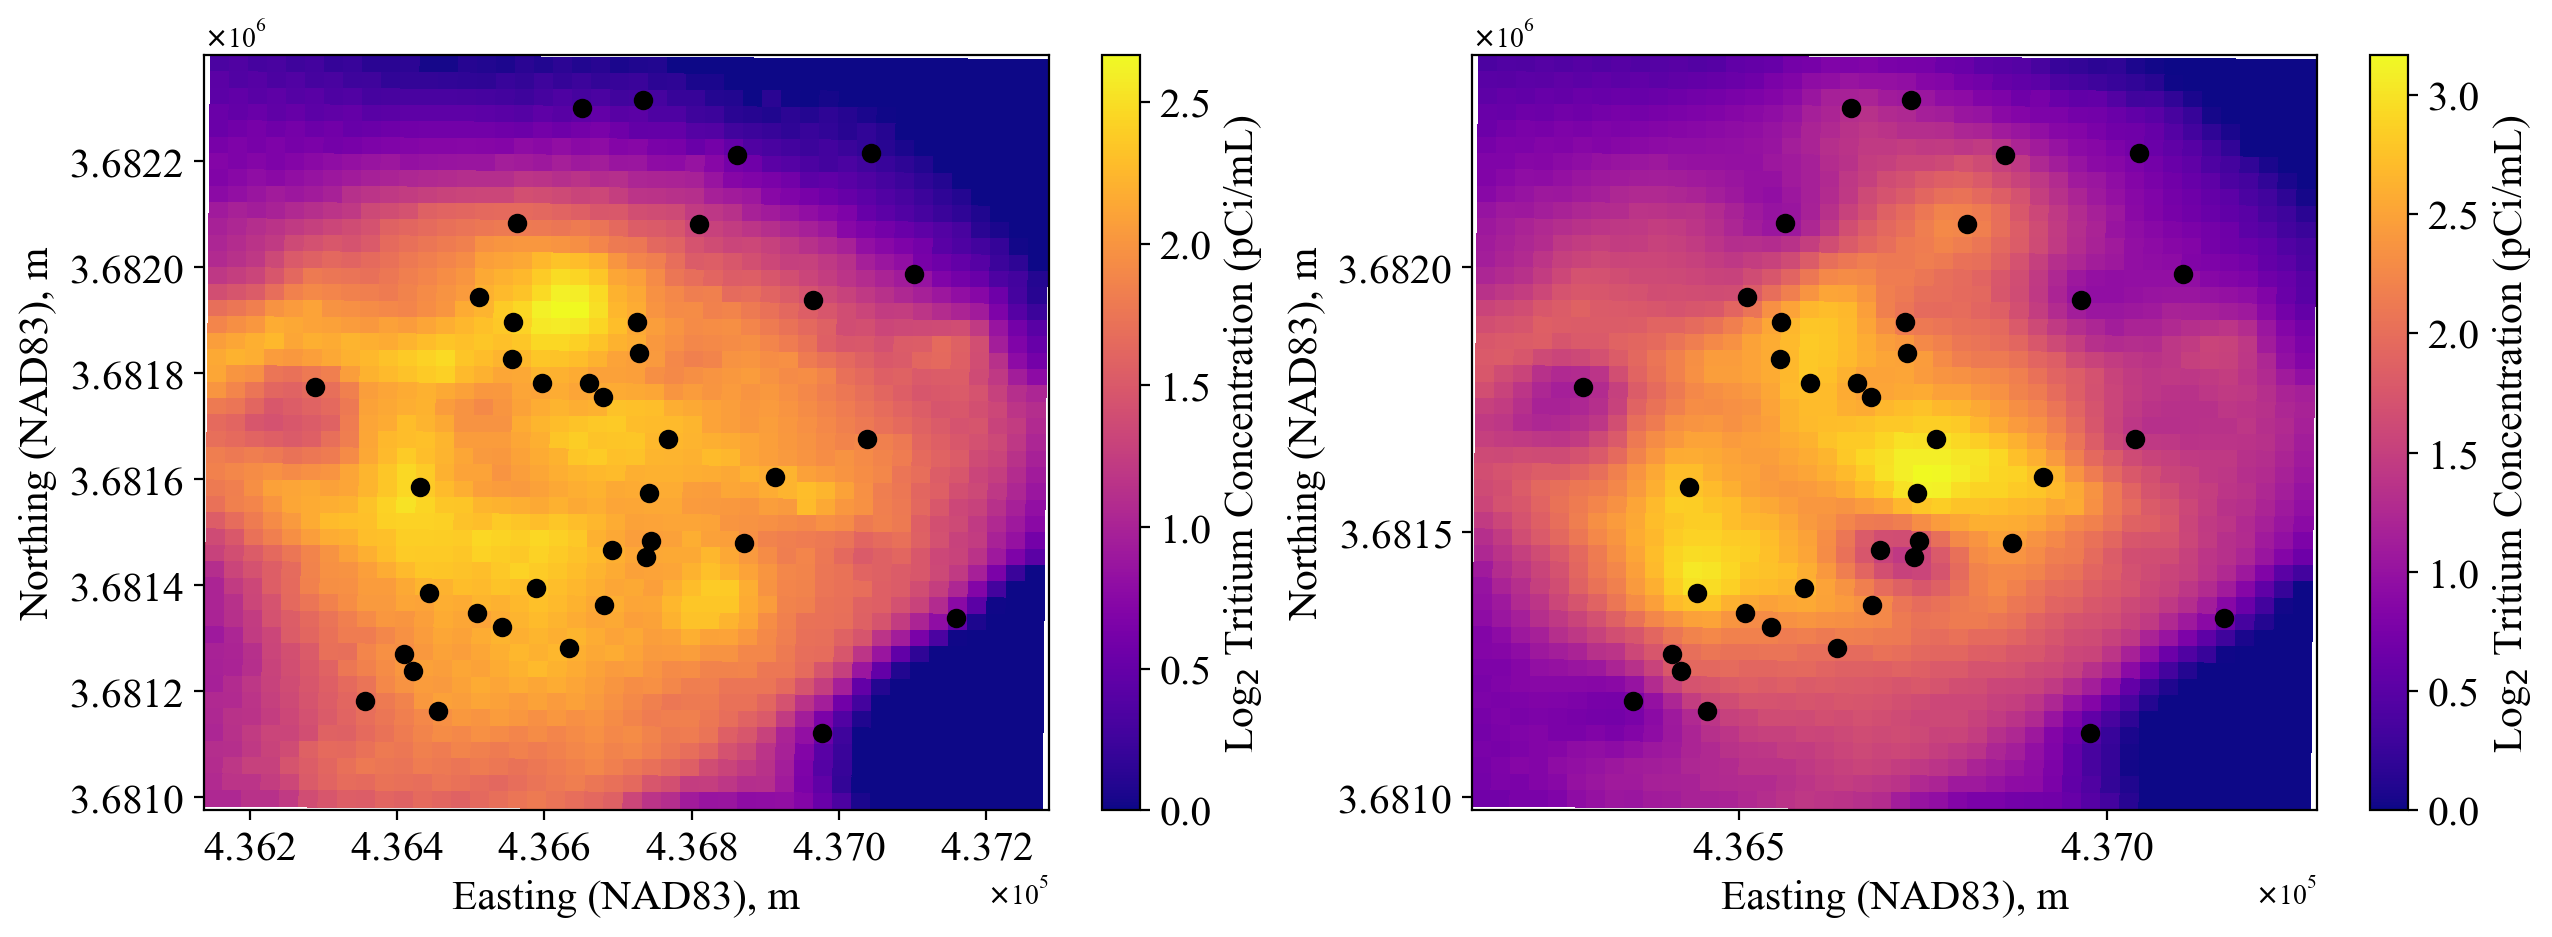

In [39]:
fig, ax = plt.subplots(1,2, figsize=(15,5), dpi=200)
plt.rc('font', size=fontsize)
# plt.locator_params(axis='both', nbins=4, tight=False)
xx = np.array(XX)
titles = [str("Linear Regression + Kriging\n Log{} Tritium Reference Field | Averaged {}".format('$_{2}$',year,)), str("Using SC as a Proxy to Tritium\nLinear Regression + Kriging\n Log{} Tritium Reference Field | Averaged {}".format('$_{2}$',year,))]
map_0 = ax[0].pcolor(xx[:,0].reshape(x_loc.shape),
                xx[:,1].reshape(x_loc.shape),
                y_map_true_tr.reshape(x_loc.shape), 
                cmap='plasma')
                # vmin=y_map_pred_tr.min(), vmax=y_map_pred_tr.max())
fig.colorbar(map_0, ax=ax[0]).set_label(label="Log{} Tritium Concentration ({})".format('$_{2}$',pylenm_df.get_unit('TRITIUM')), size=fontsize)
map_1 = ax[1].pcolor(xx[:,0].reshape(x_loc.shape),
                xx[:,1].reshape(x_loc.shape),
                y_map_pred_tr.reshape(x_loc.shape), 
                cmap='plasma')
fig.colorbar(map_1, ax=ax[1]).set_label(label="Log{} Tritium Concentration ({})".format('$_{2}$',pylenm_df.get_unit('TRITIUM')), size=fontsize)
here = ax[1]
# ax[0].scatter(X.iloc[:,0], X.iloc[:,1], c=colors, alpha=1)
for i in range(2):
    ax[i].scatter(X.iloc[:,0], X.iloc[:,1], c='black', alpha=1)
    ax[i].tick_params(axis='both', which='major', labelsize=fontsize)
    ax[i].set_xlabel("Easting (NAD83), m", fontsize=fontsize)
    ax[i].set_ylabel("Northing (NAD83), m", fontsize=fontsize)
    # ax[i].set_title(titles[i],y=1.04,fontweight='bold')
    ax[i].ticklabel_format(style='sci', axis='both',scilimits=(-1,1), useMathText=True)
plt.locator_params(axis='x', nbins=4, tight=False)
plt.locator_params(axis='y', nbins=4, tight=False)
print(r2_score(y_map_true_tr, y_map_pred_tr))
fig.show()

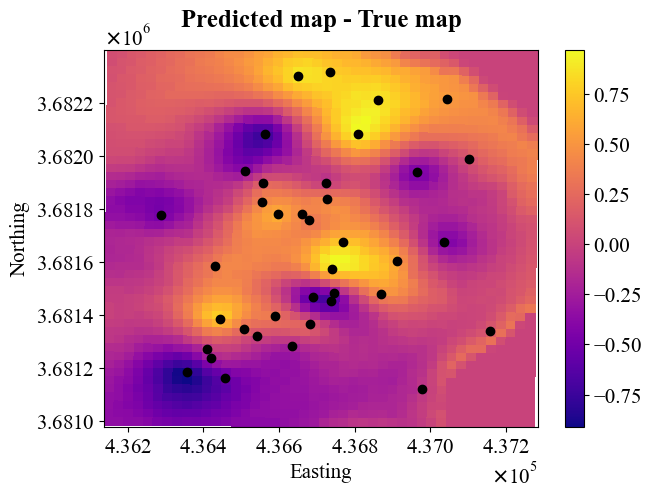

In [40]:
y_diff = y_map_pred_tr.flatten() - y_map_true_tr.flatten()
fig, ax = plt.subplots(figsize=(7,5), dpi=100)
xx = np.array(XX)
title = 'Predicted map - True map'
map_0 = ax.pcolor(xx[:,0].reshape(x_loc.shape),
                xx[:,1].reshape(x_loc.shape),
                y_diff.reshape(x_loc.shape), 
                cmap='plasma',)
                # vmin=y_map_true_tr.min(), vmax=y_map_true_tr.max())
fig.colorbar(map_0, ax=ax)

ax.scatter(X.iloc[:,0], X.iloc[:,1], c='black', alpha=1)
ax.set_xlabel("Easting")
ax.set_ylabel("Northing")
ax.set_title(title,y=1.04,fontweight='bold')
ax.ticklabel_format(style='sci', axis='both',scilimits=(-1,1), useMathText=True)
fig.show()